# Classifying handwritten digits using multilayer perceptron (MLP) model

- Handwritten digits dataset: Mixed National Institute of Standards and Technology (MNIST)
-  Constructed by Yann LeCun and others
-  Served as a popular benchmark dataset for ML algorithms
-  It consists of handwritten digits from 250 different people, 50 percent high school students and 50 percent employees from the Census Bureau
-  Each digit is discretized into 28x28=784 pixels
-  Each pixel is represented by a grayscale intensity value , 0 to 255
-  The fetch_openml function unrolls the 28x28 pixels into a 1D row vector
-  The target variable contains the class labels (integers 0 - 9) of the handwritten digits

## Obtaining and preparing the MNIST dataset

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
# In scikit-learn, the fetch_openml function downloads the MNIST dataset from OpenML (see, https://www.openml.org/search?type=data&sort=runs&id=554&status=active)
X_df, y_ds = fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
print(X_df) # X is a pandas dataframe
X = X_df.values # you can use .values to access the numpy array of a dataframe 
print(X)
print(X.shape)

       pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0           0       0       0       0       0       0       0       0       0   
1           0       0       0       0       0       0       0       0       0   
2           0       0       0       0       0       0       0       0       0   
3           0       0       0       0       0       0       0       0       0   
4           0       0       0       0       0       0       0       0       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
69995       0       0       0       0       0       0       0       0       0   
69996       0       0       0       0       0       0       0       0       0   
69997       0       0       0       0       0       0       0       0       0   
69998       0       0       0       0       0       0       0       0       0   
69999       0       0       0       0       0       0       0       0       0   

       pixel10  ...  pixel7

In [4]:
print(y_ds) # y is stored as a pandas categorical series (of string numbers) (not a dataframe)
print(y_ds.dtype) # check the type
y = y_ds.astype(int).values # convert it to integers and extract the numpy array
print(y.shape)

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']
category
(70000,)


## Normalize the pixel values to the range -1 to 1, so that the gradient-based optimization is much more stable
## Note, this is different from the feature-scaling approach discussed before. Instead, we rescale each sample, or each sample's pixel values!

In [5]:
X = ((X / 255.) - 0.5) * 2

In [6]:
print(X)

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


## Visualize the digits

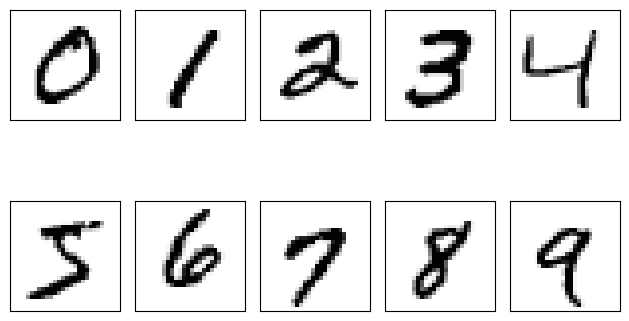

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    imag = X[y == i][0].reshape(28, 28)  # plot the first 0, 1, 2, 3, ... You can change [0] to [1], if you want to plt the second 0, 1,...
    ax[i].imshow(imag, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

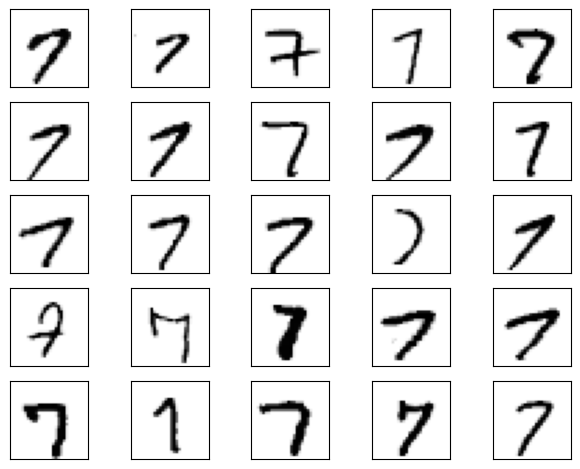

In [8]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28) # plot the top 25 digital number "7"
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## Divide the dataset into training (55000 images), validation (5000 images), and test (10000 images) subsets

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=10000, random_state=123, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

## Implementing a multilayer perceptron

### helper function for sigmoid and one-hot encoding

In [11]:
import numpy as np

# define helper functions to compute the logistic sigmoid activation function
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

# helper function to convert integer class label arrays to one-hot encoded labels:
# One-hot encoding is required for Multi-class classification
# num_labels: the number of nurons in the output layer
def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1    # change the val-th element of the i-th vector from 0 to 1
    return ary


# example: 
y_temp = np.array([0, 2, 1, 3])
num_labels_temp = 4
one_hot = int_to_onehot(y_temp, num_labels_temp)
print(one_hot)

[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


In [21]:
import numpy as np

class NeuralNetMLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        self.num_classes = num_classes

        # Initialize random number generator
        rng = np.random.RandomState(random_seed)

        # Hidden layer weights matrix and biases vector
        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # Output layer weights matrix and biases vector
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        """
        Forward pass through the MLP. Here, we apply sigmoid for both hidden layer and output layer
        
        Parameters:
        x : ndarray of shape (n_examples, n_features)
            Input features for the batch.
        
        Returns:
        a_h : ndarray of shape (n_examples, n_hidden)
            Activations from the hidden layer.
        a_out : ndarray of shape (n_examples, n_classes) 
            Activations from the output layer.
            IT REPRESENTS THE CLASS PROBABILITIES!!!!
        """
        
        # Hidden layer
        # Input dim: [n_examples, n_features]
        # Weight shape: [n_hidden, n_features]
        # Output dim after dot product: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)
    
        # Output layer
        # Input dim: [n_examples, n_hidden]
        # Weight shape: [n_classes, n_hidden]
        # Output dim after dot product: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
    
        return a_h, a_out
    
    
    def backward(self, x, a_h, a_out, y):
        """
        Backward pass through the MLP.
        
        Parameters:
        x : ndarray of shape (n_examples, n_features)
            Input features for the batch.
        a_h : ndarray of shape (n_examples, n_hidden)
            Activations from the hidden layer.
        a_out : ndarray of shape (n_examples, n_classes)
            Activations from the output layer.
        y : ndarray of shape (n_examples,)
            True class labels (integer encoded).
        
        Returns:
        d_loss__dw_out : ndarray of shape (n_classes, n_hidden)
            Gradient of loss with respect to output layer weights.
        d_loss__db_out : ndarray of shape (n_classes,)
            Gradient of loss with respect to output layer biases.
        d_loss__d_w_h : ndarray of shape (n_hidden, n_features)
            Gradient of loss with respect to hidden layer weights.
        d_loss__d_b_h : ndarray of shape (n_hidden,)
            Gradient of loss with respect to hidden layer biases.
        """
    
        #########################
        ### Output layer weights
        #########################
        # Convert labels to one-hot encoding
        y_onehot = int_to_onehot(y, self.num_classes)
    
        # Compute gradient of loss with respect to output activations
        # dLoss/dOutAct
        d_loss__d_a_out = 2.0 * (a_out - y_onehot) / y.shape[0]
    
        # Compute derivative of sigmoid activation function
        d_a_out__d_z_out = a_out * (1.0 - a_out)
    
        # Compute delta for output layer
        delta_out = d_loss__d_a_out * d_a_out__d_z_out
    
        # Compute gradients for output layer weights and biases
        d_z_out__dw_out = a_h  # Activation of hidden layer
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
    
        #################################
        ### Hidden layer weights
        #################################
        # Compute gradient of loss with respect to hidden activations
        d_z_out__a_h = self.weight_out  # Weight matrix from hidden to output layer
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
    
        # Compute derivative of sigmoid activation function for hidden layer
        d_a_h__d_z_h = a_h * (1.0 - a_h)
    
        # Compute weight gradients for the hidden layer
        d_z_h__d_w_h = x
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)
    
        return d_loss__dw_out, d_loss__db_out, d_loss__d_w_h, d_loss__d_b_h


In [22]:
## In the above, we have implemented the NeuralNetMLP class, we can use the following lines to instantiate a new NeuralNetMLP object:
model = NeuralNetMLP(
    num_features=28*28,  # 784 input features (pixels)
    num_hidden=50,        # 50 neurons in the hidden layer
    num_classes=10        # 10 output classes (digits 0-9)
)

### Train the MLP

In [23]:
import numpy as np

num_epochs = 50
minibatch_size = 100

def minibatch_generator(X, y, minibatch_size):
    """
    Generates mini-batches for training.
    
    Parameters:
    X : ndarray of shape (n_samples, n_features)
        Input data.
    y : ndarray of shape (n_samples,)
        Target labels.
    minibatch_size : int
        Number of samples per batch.

    Yields:
    X_batch : ndarray
        A mini-batch of input data.
    y_batch : ndarray
        Corresponding mini-batch of labels.
    """
    indices = np.arange(X.shape[0])  # Create array of indices
    np.random.shuffle(indices)  # Shuffle the indices

    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]  # Yield mini-batch of data


### print the minibatch to make sure it is correct. Later,  we need to remove "break"

In [24]:
# Iterate over training epochs
for i in range(num_epochs):
    # Create a minibatch generator for the current epoch
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
    
    # Iterate over minibatches
    for X_train_mini, y_train_mini in minibatch_gen:
        # Process only the first minibatch
        break  # Exit inner loop after one minibatch
    
    break  # Exit outer loop after first epoch

# Print the shape of the first mini-batch
print(X_train_mini.shape)  # Expected: (100, 784)
print(y_train_mini.shape)  # Expected: (100,)


(100, 784)
(100,)


###  define our loss function and performance metric that we can use to monitor the training process and evaluate the model. T

In [25]:
def mse_loss(targets, probas, num_labels=10):
    """
    Computes the Mean Squared Error (MSE) loss.

    Parameters:
    targets : ndarray of shape (n_samples,)
        True class labels (integer encoded).
    probas : ndarray of shape (n_samples, num_labels)
        Predicted probabilities for each class.
    num_labels : int, default=10
        Number of unique class labels.

    Returns:
    float : The MSE loss.
    """
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas) ** 2)


def accuracy(targets, predicted_labels):
    """
    Computes the classification accuracy.

    Parameters:
    targets : ndarray of shape (n_samples,)
        True class labels (integer encoded).
    predicted_labels : ndarray of shape (n_samples,)
        Predicted class labels.

    Returns:
    float : Accuracy as a proportion (0.0 to 1.0).
    """
    return np.mean(predicted_labels == targets)


### test the above functions to make sure it is correct

In [26]:
# Forward pass on the validation set
_, probas = model.forward(X_valid)

# Compute MSE loss
mse = mse_loss(y_valid, probas)
print(f'Initial validation MSE: {mse:.1f}')

# Predict class labels (choose the index of the highest probability)
predicted_labels = np.argmax(probas, axis=1)

# Compute accuracy
acc = accuracy(y_valid, predicted_labels)
print(f'Initial validation accuracy: {acc * 100:.1f}%')


Initial validation MSE: 0.3
Initial validation accuracy: 9.4%


### This is an untrained network, thus the prediction is kind of a random guess,  1 over 10 possibilities, so 9.4% is a reasonable number

### Now, we compute the MSE and accuracy incrementally by iterating over the dataset one mini-batch at a time to be more efficient

In [27]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    """
    Computes the Mean Squared Error (MSE) loss and accuracy over the dataset.

    Parameters:
    nnet : NeuralNetMLP
        The trained neural network model.
    X : ndarray of shape (n_samples, n_features)
        Input data.
    y : ndarray of shape (n_samples,)
        Target class labels.
    num_labels : int, default=10
        Number of class labels (for one-hot encoding).
    minibatch_size : int, default=100
        Batch size for processing.

    Returns:
    mse : float
        Mean Squared Error loss over all mini-batches.
    acc : float
        Accuracy over the dataset.
    """
    mse, correct_pred, num_examples = 0.0, 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    
    num_batches = 0  # Count the number of mini-batches processed

    for features, targets in minibatch_gen:
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        # Convert targets to one-hot encoding
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)

        # Compute MSE loss for this batch
        loss = np.mean((onehot_targets - probas) ** 2)
        mse += loss  # Accumulate MSE loss over mini-batches

        # Count correctly predicted samples
        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        
        num_batches += 1  # Track number of batches

    # Compute average MSE over all mini-batches
    mse /= num_batches  

    # Compute accuracy as a percentage
    acc = correct_pred / num_examples

    return mse, acc


### Before implement the training, let's test the function to make sure it works as intended

In [28]:
# Compute initial MSE and accuracy on validation set
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)

# Print results
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc * 100:.1f}%')


Initial valid MSE: 0.3
Initial valid accuracy: 9.4%


### Now the  main part: train our model

In [29]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    """
    Trains the neural network using mini-batch gradient descent.

    Parameters:
    model : NeuralNetMLP
        The neural network model.
    X_train : ndarray of shape (n_samples, n_features)
        Training data.
    y_train : ndarray of shape (n_samples,)
        Training labels.
    X_valid : ndarray of shape (n_samples, n_features)
        Validation data.
    y_valid : ndarray of shape (n_samples,)
        Validation labels.
    num_epochs : int
        Number of training epochs.
    learning_rate : float, default=0.1
        Learning rate for weight updates.

    Returns:
    epoch_loss : list
        List of training losses per epoch.
    epoch_train_acc : list
        List of training accuracies per epoch.
    epoch_valid_acc : list
        List of validation accuracies per epoch.
    """
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):
        # Iterate over mini-batches
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, \
            d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)

        # Convert accuracy to percentage
        train_acc *= 100
        valid_acc *= 100

        # Store epoch metrics
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)

        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc


### execute the above function to train our model for 50 epochs

Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 76.15% | Valid Acc: 75.98%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 85.45% | Valid Acc: 85.04%
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 87.82% | Valid Acc: 87.60%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 89.36% | Valid Acc: 89.28%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.21% | Valid Acc: 90.04%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.67% | Valid Acc: 90.54%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 91.12% | Valid Acc: 90.82%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 91.43% | Valid Acc: 91.26%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 91.84% | Valid Acc: 91.50%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.04% | Valid Acc: 91.84%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 92.30% | Valid Acc: 92.08%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 92.51% | Valid Acc: 92.24%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 92.65% | Valid Acc: 92.30%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 92.80

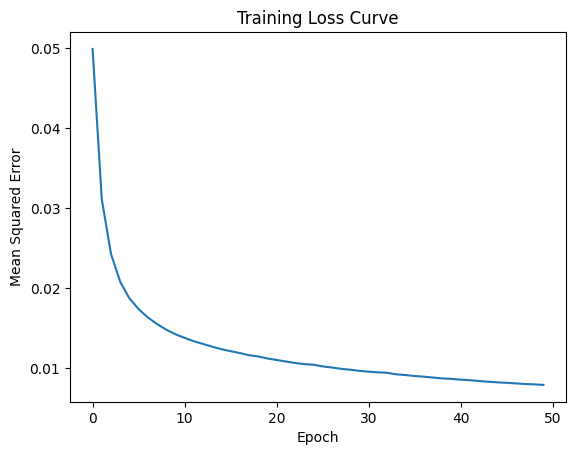

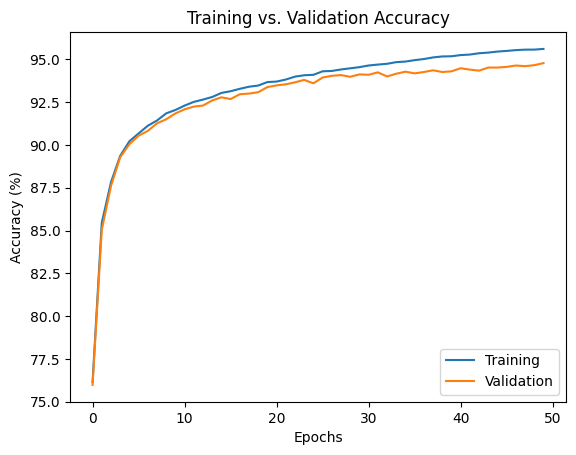

Test Accuracy: 94.54%


In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(123)

# Train the model
epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1
)

# Plot training loss over epochs
plt.plot(range(len(epoch_loss)), epoch_loss, label='Training Loss')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.title('Training Loss Curve')
plt.show()

# Plot training and validation accuracy
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.title('Training vs. Validation Accuracy')
plt.show()

# Evaluate model on test set
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test Accuracy: {test_acc * 100:.2f}%')


### take a look at a few images our MLP struggles to recognize

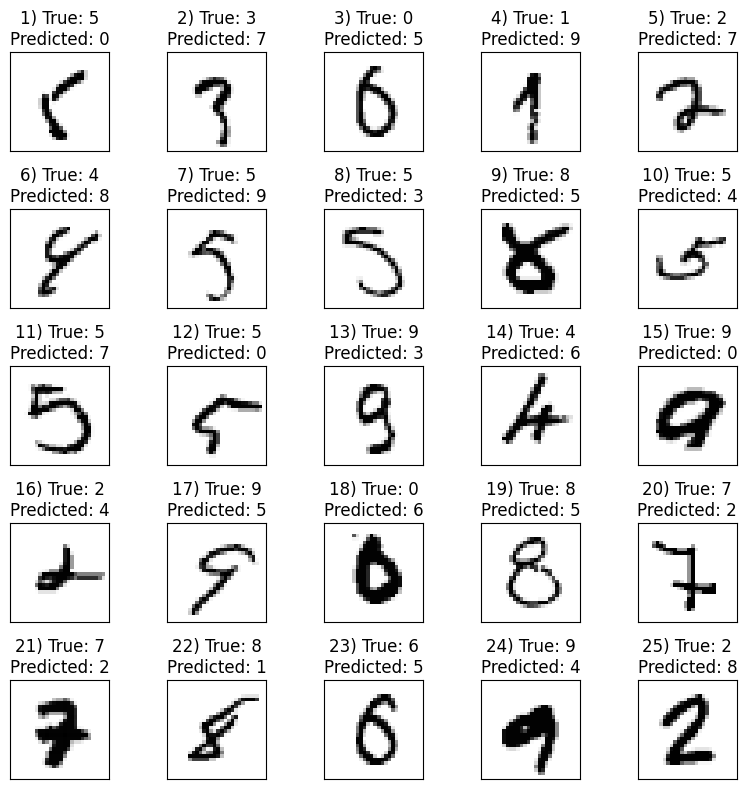

In [31]:
import matplotlib.pyplot as plt

# Select a subset of test data
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

# Forward pass to get predicted probabilities
_, probas = model.forward(X_test_subset)

# Get predicted class labels
test_pred = np.argmax(probas, axis=1)

# Identify misclassified samples
misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

# Plot misclassified images
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()

for i in range(len(misclassified_images)):
    img = misclassified_images[i].reshape(28, 28)  # Reshape flattened image to 28x28
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) True: {correct_labels[i]}\nPredicted: {misclassified_labels[i]}')

# Remove ticks for a cleaner look
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

plt.tight_layout()
plt.show()
